# Import and Define

Project 3: Multi-Modal Deep Learning Model for Fake News Detection

Authors Jason Phillips and Peeja

In [ ]:
#Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#Install necessary packages
!pip install tf-explain
!pip install --upgrade gensim
#!pip install numpy --upgrade

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 KB 1.6 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [145]:
#Import and print out the current version of packages.
%load_ext tensorboard

import tensorflow as tf
import tf_explain
import numpy as np
import matplotlib.pyplot as plt
import sys
import sklearn as sk
import pandas as pd
import shutil
import os
import imblearn
import io
import requests
import datetime

from scipy.stats import zscore
from scipy import spatial

from collections.abc import Sequence
from collections import Counter
from numpy import where
from matplotlib import pyplot

from imblearn.over_sampling import SMOTE

from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn import metrics
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import roc_curve, auc
from sklearn.manifold import TSNE

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Model
from tensorflow.keras.utils import plot_model
from tensorflow.keras.optimizers import Adam

from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D,LSTM
from keras.activations import relu, sigmoid, tanh
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
from keras import optimizers

from gensim.models import Word2Vec
from gensim import corpora
from gensim.utils import simple_preprocess
from gensim.models import KeyedVectors

from nltk.stem.lancaster import LancasterStemmer
from nltk.tokenize import RegexpTokenizer
from PIL import UnidentifiedImageError


# Encode text values to dummy variables(i.e. [1,0,0],[0,1,0],[0,0,1] for red,green,blue)
def encode_text_dummy(df, name):
    dummies = pd.get_dummies(df[name])
    for x in dummies.columns:
        dummy_name = "{}-{}".format(name, x)
        df[dummy_name] = dummies[x]
    df.drop(name, axis=1, inplace=True)


# Encode text values to indexes(i.e. [1],[2],[3] for red,green,blue).
def encode_text_index(df, name):
    le = preprocessing.LabelEncoder()
    df[name] = le.fit_transform(df[name])
    return le.classes_


# Encode a numeric column as zscores
def encode_numeric_zscore(df, name, mean=None, sd=None):
    if mean is None:
        mean = df[name].mean()

    if sd is None:
        sd = df[name].std()

    df[name] = (df[name] - mean) / sd


# Convert all missing values in the specified column to the median
def missing_median(df, name):
    med = df[name].median()
    df[name] = df[name].fillna(med)


# Convert all missing values in the specified column to the default
def missing_default(df, name, default_value):
    df[name] = df[name].fillna(default_value)


# Convert a Pandas dataframe to the x,y inputs that TensorFlow needs
def to_xy(df, target):
    result = []
    for x in df.columns:
        if x != target:
            result.append(x)
    # find out the type of the target column. 
    target_type = df[target].dtypes
    target_type = target_type[0] if isinstance(target_type, Sequence) else target_type
    # Encode to int for classification, float otherwise. TensorFlow likes 32 bits.
    if target_type in (np.int64, np.int32):
        # Classification
        dummies = pd.get_dummies(df[target])
        return df[result].values.astype(np.float32), dummies.values.astype(np.float32)
    else:
        # Regression
        return df[result].values.astype(np.float32), df[target].values.astype(np.float32)

# Nicely formatted time string
def hms_string(sec_elapsed):
    h = int(sec_elapsed / (60 * 60))
    m = int((sec_elapsed % (60 * 60)) / 60)
    s = sec_elapsed % 60
    return "{}:{:>02}:{:>05.2f}".format(h, m, s)


# Regression chart.
def chart_regression(pred,y,sort=True):
    t = pd.DataFrame({'pred' : pred, 'y' : y.flatten()})
    if sort:
        t.sort_values(by=['y'],inplace=True)
    a = plt.plot(t['y'].tolist(),label='expected')
    b = plt.plot(t['pred'].tolist(),label='prediction')
    plt.ylabel('output')
    plt.legend()
    plt.show()

# Remove all rows where the specified column is +/- sd standard deviations
def remove_outliers(df, name, sd):
    drop_rows = df.index[(np.abs(df[name] - df[name].mean()) >= (sd * df[name].std()))]
    df.drop(drop_rows, axis=0, inplace=True)


# Encode a column to a range between normalized_low and normalized_high.
def encode_numeric_range(df, name, normalized_low=-1, normalized_high=1,
                         data_low=None, data_high=None):
    if data_low is None:
        data_low = min(df[name])
        data_high = max(df[name])

    df[name] = ((df[name] - data_low) / (data_high - data_low)) * (normalized_high - normalized_low) + normalized_low

# Plot a confusion matrix.
# cm is the confusion matrix, names are the names of the classes.
def plot_confusion_matrix(cm, names, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(names))
    plt.xticks(tick_marks, names, rotation=45)
    plt.yticks(tick_marks, names)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    

# Plot an ROC. pred - the predictions, y - the expected output.
def plot_roc(pred,y):
    fpr, tpr, thresholds = roc_curve(y, pred)
    roc_auc = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC)')
    plt.legend(loc="lower right")
    plt.show()

def to_sequences(seq_size, data):
    x = []
    y = []

    for i in range(len(data)-SEQUENCE_SIZE-1):
        #print(i)
        window = data[i:(i+SEQUENCE_SIZE)]
        after_window = data[i+SEQUENCE_SIZE]
        window = [[x] for x in window]
        #print("{} - {}".format(window,after_window))
        x.append(window)
        y.append(after_window)
        
    return np.array(x),np.array(y)

print('Python {}'.format(sys.version))
print('Pandas {}'.format(pd.__version__))
print('Numpy {}'.format(np.__version__))
print('Scikit-Learn {}'.format(sk.__version__))
print()
print('Tensor Flow {}'.format(tf.__version__))
print('Keras {}'.format(tf.keras.__version__))
print('Imblearn {}'.format(imblearn.__version__))


#Function for the Scatterplot
def display_closestwords_tsnescatterplot(model, word):
    
    arr = np.empty((0,300), dtype='f')
    word_labels = [word]

    # get close words
    close_words = model.wv.similar_by_word(word)
    
    # add the vector for each of the closest words to the array
    arr = np.append(arr, np.array([model.wv[word]]), axis=0)
    for wrd_score in close_words:
        wrd_vector = model.wv[wrd_score[0]]
        word_labels.append(wrd_score[0])
        arr = np.append(arr, np.array([wrd_vector]), axis=0)
        
    # find tsne coords for 2 dimensions
    tsne = TSNE(n_components=2, perplexity= 10, random_state=0)
    np.set_printoptions(suppress=True)
    Y = tsne.fit_transform(arr)

    x_coords = Y[:, 0]
    y_coords = Y[:, 1]
    # display scatter plot
    plt.scatter(x_coords, y_coords)

    for label, x, y in zip(word_labels, x_coords, y_coords):
        plt.annotate(label, xy=(x, y), xytext=(0, 0), textcoords='offset points')
    plt.xlim(x_coords.min()+0.00005, x_coords.max()+0.00005)
    plt.ylim(y_coords.min()+0.00005, y_coords.max()+0.00005)
    plt.show()

#Remove any files in the log folder for tensorboard
!rm -rf "/content/drive/MyDrive/Colab Notebooks/logs/"

#Define the log folder for tensorboard
log_dir = "/content/drive/MyDrive/Colab Notebooks/logs/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")


The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard
Python 3.9.16 (main, Dec  7 2022, 01:11:51) 
[GCC 9.4.0]
Pandas 1.4.4
Numpy 1.22.4
Scikit-Learn 1.2.2

Tensor Flow 2.11.0
Keras 2.11.0
Imblearn 0.10.1


#Training Data Preprocessing

Takes training data and produces tweets_train array.

In [192]:
#Read the tweets.txt file from training folder
filename_read = "/content/drive/MyDrive/Colab Notebooks/data/devset/tweets.txt"
df_train = pd.read_csv(filename_read, sep='\t', header=0)
df_train

,tweetId,tweetText,userId,imageId(s),username,timestamp,label
0,263046056240115712,¿Se acuerdan de la película: “El día después d...,21226711,sandyA_fake_46,iAnnieM,Mon Oct 29 22:34:01 +0000 2012,fake
1,262995061304852481,@milenagimon: Miren a Sandy en NY! Tremenda i...,192378571,sandyA_fake_09,CarlosVerareal,Mon Oct 29 19:11:23 +0000 2012,fake
2,262979898002534400,"Buena la foto del Huracán Sandy, me recuerda a...",132303095,sandyA_fake_09,LucasPalape,Mon Oct 29 18:11:08 +0000 2012,fake
3,262996108400271360,Scary shit #hurricane #NY http://t.co/e4JLBUfH,241995902,sandyA_fake_29,Haaaaarryyy,Mon Oct 29 19:15:33 +0000 2012,fake
4,263018881839411200,My fave place in the world #nyc #hurricane #sa...,250315890,sandyA_fake_15,princess__natt,Mon Oct 29 20:46:02 +0000 2012,fake
...,...,...,...,...,...,...,...
14272,443231991593304064,@BobombDom *slaps TweetDeck with the PigFish h...,2179310905,pigFish_01,Da_Vault_Hunter,Tue Mar 11 03: 48: 36 +0000 2014,fake
14273,443086239127076865,New Species of Fish found in Brazil or just Re...,254843101,pigFish_01,DjSituation_RC,Mon Mar 10 18: 09: 26 +0000 2014,fake
14274,442978105238753280,What do we call this? #pigFISH http: \/\/t.co\...,2367553228,pigFish_01,Vivo1Vuyo,Mon Mar 10 10: 59: 45 +0000 2014,fake
14275,442753479782989824,Pigfish ? E dopo il pescecane c'è il pesce mai...,603120231,pigFish_01,CosimoTarta,Sun Mar 09 20: 07: 10 +0000 2014,fake


In [193]:
print("Training data shape: " + str(df_train.shape))

Training data shape: (14277, 7)


In [194]:
#Remove humor label because we only want real/fake tweets
df_train = df_train[df_train["label"] != "humor"]
print("Training data shape after humor removed: " + str(df_train.shape))

Training data shape after humor removed: (11663, 7)


In [195]:
df_train

,tweetId,tweetText,userId,imageId(s),username,timestamp,label
0,263046056240115712,¿Se acuerdan de la película: “El día después d...,21226711,sandyA_fake_46,iAnnieM,Mon Oct 29 22:34:01 +0000 2012,fake
1,262995061304852481,@milenagimon: Miren a Sandy en NY! Tremenda i...,192378571,sandyA_fake_09,CarlosVerareal,Mon Oct 29 19:11:23 +0000 2012,fake
2,262979898002534400,"Buena la foto del Huracán Sandy, me recuerda a...",132303095,sandyA_fake_09,LucasPalape,Mon Oct 29 18:11:08 +0000 2012,fake
3,262996108400271360,Scary shit #hurricane #NY http://t.co/e4JLBUfH,241995902,sandyA_fake_29,Haaaaarryyy,Mon Oct 29 19:15:33 +0000 2012,fake
4,263018881839411200,My fave place in the world #nyc #hurricane #sa...,250315890,sandyA_fake_15,princess__natt,Mon Oct 29 20:46:02 +0000 2012,fake
...,...,...,...,...,...,...,...
14272,443231991593304064,@BobombDom *slaps TweetDeck with the PigFish h...,2179310905,pigFish_01,Da_Vault_Hunter,Tue Mar 11 03: 48: 36 +0000 2014,fake
14273,443086239127076865,New Species of Fish found in Brazil or just Re...,254843101,pigFish_01,DjSituation_RC,Mon Mar 10 18: 09: 26 +0000 2014,fake
14274,442978105238753280,What do we call this? #pigFISH http: \/\/t.co\...,2367553228,pigFish_01,Vivo1Vuyo,Mon Mar 10 10: 59: 45 +0000 2014,fake
14275,442753479782989824,Pigfish ? E dopo il pescecane c'è il pesce mai...,603120231,pigFish_01,CosimoTarta,Sun Mar 09 20: 07: 10 +0000 2014,fake


In [196]:
#Remove any tweets with no corresponding images
df_train = df_train[df_train["imageId(s)"] != ""]
print("Training data shape after empty images removed: " + str(df_train.shape))

Training data shape after empty images removed: (11663, 7)


In [197]:
df_train=df_train[df_train["imageId(s)"] != "boston_fake_35"] 

In [198]:
df_train.to_csv("/content/drive/MyDrive/Colab Notebooks/data/devset/tweets_dataframe.csv", index=False)

In [199]:
#Tokenize the tweets to get individual words per row.
tkr = RegexpTokenizer("[a-zA-Záéíóúñ']+")
df_train['tokenized'] = df_train['tweetText'].apply(lambda row: [t.lower() for t in tkr.tokenize(row)])
df_train['tokenized']

0        [se, acuerdan, de, la, película, el, día, desp...
1        [milenagimon, miren, a, sandy, en, ny, tremend...
2        [buena, la, foto, del, huracán, sandy, me, rec...
3        [scary, shit, hurricane, ny, http, t, co, e, j...
4        [my, fave, place, in, the, world, nyc, hurrica...
                               ...                        
14272    [bobombdom, slaps, tweetdeck, with, the, pigfi...
14273    [new, species, of, fish, found, in, brazil, or...
14274    [what, do, we, call, this, pigfish, http, t, c...
14275    [pigfish, e, dopo, il, pescecane, c', il, pesc...
14276    [for, those, who, can't, decide, between, fish...
Name: tokenized, Length: 11662, dtype: object

In [200]:
df_train

,tweetId,tweetText,userId,imageId(s),username,timestamp,label,tokenized
0,263046056240115712,¿Se acuerdan de la película: “El día después d...,21226711,sandyA_fake_46,iAnnieM,Mon Oct 29 22:34:01 +0000 2012,fake,"[se, acuerdan, de, la, película, el, día, desp..."
1,262995061304852481,@milenagimon: Miren a Sandy en NY! Tremenda i...,192378571,sandyA_fake_09,CarlosVerareal,Mon Oct 29 19:11:23 +0000 2012,fake,"[milenagimon, miren, a, sandy, en, ny, tremend..."
2,262979898002534400,"Buena la foto del Huracán Sandy, me recuerda a...",132303095,sandyA_fake_09,LucasPalape,Mon Oct 29 18:11:08 +0000 2012,fake,"[buena, la, foto, del, huracán, sandy, me, rec..."
3,262996108400271360,Scary shit #hurricane #NY http://t.co/e4JLBUfH,241995902,sandyA_fake_29,Haaaaarryyy,Mon Oct 29 19:15:33 +0000 2012,fake,"[scary, shit, hurricane, ny, http, t, co, e, j..."
4,263018881839411200,My fave place in the world #nyc #hurricane #sa...,250315890,sandyA_fake_15,princess__natt,Mon Oct 29 20:46:02 +0000 2012,fake,"[my, fave, place, in, the, world, nyc, hurrica..."
...,...,...,...,...,...,...,...,...
14272,443231991593304064,@BobombDom *slaps TweetDeck with the PigFish h...,2179310905,pigFish_01,Da_Vault_Hunter,Tue Mar 11 03: 48: 36 +0000 2014,fake,"[bobombdom, slaps, tweetdeck, with, the, pigfi..."
14273,443086239127076865,New Species of Fish found in Brazil or just Re...,254843101,pigFish_01,DjSituation_RC,Mon Mar 10 18: 09: 26 +0000 2014,fake,"[new, species, of, fish, found, in, brazil, or..."
14274,442978105238753280,What do we call this? #pigFISH http: \/\/t.co\...,2367553228,pigFish_01,Vivo1Vuyo,Mon Mar 10 10: 59: 45 +0000 2014,fake,"[what, do, we, call, this, pigfish, http, t, c..."
14275,442753479782989824,Pigfish ? E dopo il pescecane c'è il pesce mai...,603120231,pigFish_01,CosimoTarta,Sun Mar 09 20: 07: 10 +0000 2014,fake,"[pigfish, e, dopo, il, pescecane, c', il, pesc..."


In [201]:
#create an array of each row tokenized
tweets_train = df_train['tokenized']
print(tweets_train)

0        [se, acuerdan, de, la, película, el, día, desp...
1        [milenagimon, miren, a, sandy, en, ny, tremend...
2        [buena, la, foto, del, huracán, sandy, me, rec...
3        [scary, shit, hurricane, ny, http, t, co, e, j...
4        [my, fave, place, in, the, world, nyc, hurrica...
                               ...                        
14272    [bobombdom, slaps, tweetdeck, with, the, pigfi...
14273    [new, species, of, fish, found, in, brazil, or...
14274    [what, do, we, call, this, pigfish, http, t, c...
14275    [pigfish, e, dopo, il, pescecane, c', il, pesc...
14276    [for, those, who, can't, decide, between, fish...
Name: tokenized, Length: 11662, dtype: object


#Testing Data Preprocessing

Takes test data and produces tweets_train array.

In [202]:
#Read the tweets_test.txt file from test folder
filename_read = "/content/drive/MyDrive/Colab Notebooks/data/devset/tweets_test.txt"
df_test = pd.read_csv(filename_read, sep='\t', header=0)
df_test

,tweetId,tweetText,userId,imageId(s),username,timestamp,label
0,578854927457349632,kereeen RT @Shyman33: Eclipse from ISS.... htt...,70824972,eclipse_01,peay_s,Fri Mar 20 09:45:43 +0000 2015,fake
1,578874632670953472,Absolutely beautiful! RT @Shyman33: Eclipse fr...,344707006,eclipse_01,JaredUcanChange,Fri Mar 20 11:04:02 +0000 2015,fake
2,578891261353984000,“@Shyman33: Eclipse from ISS.... http://t.co/C...,224839607,eclipse_01,tpjp1231,Fri Mar 20 12:10:06 +0000 2015,fake
3,578846612312748032,Eclipse from ISS.... http://t.co/En87OtvsU6,134543073,eclipse_01,Shyman33,Fri Mar 20 09:12:41 +0000 2015,fake
4,578975333841551360,@ebonfigli: Éclipse vue de l'ISS... Autre chos...,1150728872,eclipse_01,Epimethee_,Fri Mar 20 17:44:11 +0000 2015,fake
...,...,...,...,...,...,...,...
3750,578433150071775232,Un présentateur de la ZDF confesse avoir truqu...,257551211,varoufakis_1,Cdt_Sylvestre,Thu Mar 19 05:49:44 +0000 2015,fake
3751,578433646597656576,"Oh les kleine menteurs ""@CorineBarella: Un pré...",27575883,varoufakis_1,damomarc,Thu Mar 19 05:51:42 +0000 2015,fake
3752,578486910491996160,Este es el programa de ZDF en el que confirman...,2049211,varoufakis_1,javierpascual,Thu Mar 19 09:23:21 +0000 2015,fake
3753,578505023912591360,11.34 - wir haben FAST Mittag ▶ Riesen Verwirr...,262222386,varoufakis_1,aotto1968_2,Thu Mar 19 10:35:20 +0000 2015,fake


In [203]:
print("Test data shape: " + str(df_test.shape))

Test data shape: (3755, 7)


In [204]:
#Remove humor label because we only want real/fake tweets
df_test = df_test[df_test["label"] != "humor"]
print("Test data shape after humor removed: " + str(df_test.shape))

Test data shape after humor removed: (3755, 7)


In [205]:
#df_test=df_test[df_test["imageId(s)"] != "boston_fake_35"] 

In [206]:
#Remove any tweets with no corresponding images
df_test = df_test[df_test["imageId(s)"] != ""]
print("Test data shape after empty images removed: " + str(df_test.shape))

Test data shape after empty images removed: (3755, 7)


In [207]:
df_test.to_csv("/content/drive/MyDrive/Colab Notebooks/data/devset/tweets_test_dataframe.csv", index=False)

In [208]:
#Tokenize the tweets to get individual words per row.
tkr = RegexpTokenizer("[a-zA-Záéíóúñ']+")
df_test['tokenized'] = df_test['tweetText'].apply(lambda row: [t.lower() for t in tkr.tokenize(row)])
df_test['tokenized']

0       [kereeen, rt, shyman, eclipse, from, iss, http...
1       [absolutely, beautiful, rt, shyman, eclipse, f...
2       [shyman, eclipse, from, iss, http, t, co, c, v...
3            [eclipse, from, iss, http, t, co, en, otvsu]
4       [ebonfigli, clipse, vue, de, l'iss, autre, cho...
                              ...                        
3750    [un, présentateur, de, la, zdf, confesse, avoi...
3751    [oh, les, kleine, menteurs, corinebarella, un,...
3752    [este, es, el, programa, de, zdf, en, el, que,...
3753    [wir, haben, fast, mittag, riesen, verwirrung,...
3754    [sorry, yanisvaroufakis, https, t, co, bskyrbi...
Name: tokenized, Length: 3755, dtype: object

In [209]:
#create an array of each row tokenized
tweets_test = df_test['tokenized']
print(tweets_test[0])

['kereeen', 'rt', 'shyman', 'eclipse', 'from', 'iss', 'http', 't', 'co', 'je', 'hcfpvfn']


# Word2Vec Transfer Learning (Training Set)
Using google's model on our vocabulary for our Training set.



In [210]:
#Word2vec model for our TRAINING dataset
# size option needs to be set to 300 to be the same as Google's pre-trained model 
word2vec_model_train = Word2Vec(vector_size=300, min_count=5, sg=1, window=5, epochs=300)

word2vec_model_train.build_vocab(tweets_train)

word2vec_model_train.wv.vectors_lockf = np.ones(len(word2vec_model_train.wv))

# assign the vectors to the vocabs that are in Google's pre-trained model and your sentences defined above.
# lockf needs to be set to 1.0 to allow continued training.
word2vec_model_train.wv.intersect_word2vec_format('/content/drive/MyDrive/Colab Notebooks/data/GoogleNews-vectors-negative300.bin.gz', lockf=1.0, binary=True)

In [211]:
#This will update existing weights based off our vocabulary.
word2vec_model_train.train(tweets_train,  # Our training dataset 
                     total_examples=11662,          #might have to change this     
                     epochs = 5)

(512434, 929450)

In [212]:
#Save the model and load it for faster processing
word2vec_model_train.save('word2vec_model_transfer')
word2vec_model_train = Word2Vec.load('word2vec_model_transfer')


In [213]:
#Display similar data to chosen word
word2vec_model_train.wv.most_similar(positive=['boston'], topn=20)

[('nyc', 0.6515336036682129),
 ('bostonmarathon', 0.597902238368988),
 ('cambridge', 0.5887125730514526),
 ('brooklyn', 0.5580998063087463),
 ('connecticut', 0.5555818676948547),
 ('bostonstrong', 0.5473113656044006),
 ('washington', 0.5434766411781311),
 ('louisiana', 0.5401884317398071),
 ('virginia', 0.5396131277084351),
 ('maryland', 0.5347602367401123),
 ('york', 0.5340389609336853),
 ('nbc', 0.5297824740409851),
 ('nw', 0.5281549692153931),
 ('tj', 0.5194971561431885),
 ('france', 0.5189995765686035),
 ('usa', 0.5113814473152161),
 ('kc', 0.5045082569122314),
 ('plymouth', 0.5031690001487732),
 ('aj', 0.49162909388542175),
 ('tho', 0.4885568916797638)]

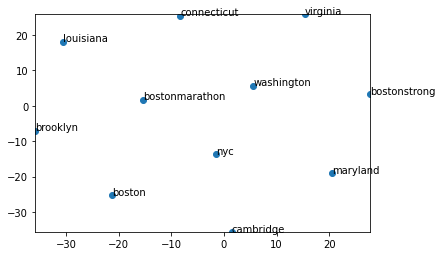

In [214]:
#Visualize the similar words on a scatter plot
display_closestwords_tsnescatterplot(word2vec_model_train,'boston')

In [215]:
#Display the vector for the word boston.
word2vec_model_train.wv['boston']

array([-0.51171875, -0.08544922, -0.06054688,  0.43359375,  0.19433594,
       -0.18457031, -0.12792969, -0.30859375, -0.09716797, -0.02734375,
       -0.5859375 , -0.5       , -0.41796875, -0.13574219,  0.30664062,
        0.24414062,  0.11621094, -0.35546875,  0.3125    , -0.25585938,
       -0.15917969,  0.00506592,  0.15917969, -0.05786133, -0.44726562,
        0.18652344, -0.27148438,  0.24902344, -0.42773438,  0.08398438,
        0.07373047,  0.09521484, -0.06445312, -0.14355469, -0.12011719,
       -0.00128937, -0.11425781,  0.07763672,  0.2578125 , -0.03173828,
        0.03442383, -0.08349609,  0.08496094, -0.09179688, -0.09277344,
        0.06884766, -0.00053787, -0.33789062, -0.09228516,  0.10888672,
        0.10986328,  0.15917969,  0.05615234,  0.20507812, -0.01647949,
       -0.04321289, -0.15527344, -0.10986328, -0.10009766,  0.0480957 ,
       -0.0402832 , -0.04370117, -0.08984375, -0.14941406,  0.06005859,
       -0.671875  , -0.10839844,  0.07714844,  0.09912109,  0.15

In [216]:
word2vec_model_train.wv['se']

array([-0.19726562,  0.1484375 ,  0.19335938,  0.00124359, -0.06494141,
        0.13671875,  0.006073  ,  0.125     ,  0.04125977,  0.05297852,
       -0.27734375, -0.33203125, -0.578125  ,  0.15039062, -0.19824219,
        0.33398438,  0.35742188,  0.625     ,  0.0402832 ,  0.25585938,
       -0.2109375 , -0.19140625,  0.08789062,  0.2890625 , -0.2890625 ,
       -0.05126953, -0.39453125,  0.07324219, -0.05737305,  0.06103516,
       -0.04296875,  0.13378906,  0.04516602, -0.21582031, -0.30859375,
       -0.23632812, -0.23339844,  0.25976562,  0.37304688, -0.09960938,
       -0.00927734, -0.14453125,  0.08691406,  0.26953125, -0.18652344,
       -0.0177002 , -0.19726562,  0.06152344, -0.10351562,  0.07226562,
       -0.11767578,  0.26171875,  0.01855469,  0.234375  , -0.21386719,
       -0.05541992, -0.25976562, -0.04711914, -0.09326172, -0.23730469,
       -0.33007812,  0.12158203, -0.08203125, -0.02697754,  0.07275391,
        0.00759888, -0.02978516, -0.04345703, -0.23144531,  0.28

In [217]:
word2vec_model_train.wv[0].shape

(300,)

In [218]:
words = list(word2vec_model_train.wv.index_to_key)
words

['t',
 'co',
 'http',
 'sandy',
 'the',
 'hurricane',
 'of',
 'in',
 'a',
 'this',
 'rt',
 'is',
 'new',
 'hurricanesandy',
 'nyc',
 'to',
 'de',
 'photo',
 'york',
 'jersey',
 'n',
 'i',
 'from',
 'for',
 'on',
 'at',
 'and',
 'o',
 'shark',
 'ny',
 'tomb',
 'via',
 'cover',
 'are',
 'real',
 'unknown',
 'amazing',
 'newyork',
 'you',
 'nj',
 'wow',
 'my',
 'la',
 'en',
 'no',
 'el',
 'soldier',
 'during',
 'out',
 'picture',
 'that',
 'by',
 'storm',
 'pic',
 's',
 'it',
 'huracán',
 'manhattan',
 'boston',
 'crazy',
 'nymag',
 'after',
 'swimming',
 'sochi',
 'was',
 'mh',
 'q',
 'sharks',
 'be',
 'like',
 'e',
 'cuba',
 'suspect',
 'y',
 'with',
 'so',
 'not',
 'soldiers',
 'foto',
 'c',
 'j',
 'que',
 'fake',
 'over',
 'x',
 'city',
 'f',
 'people',
 'all',
 'an',
 'h',
 'about',
 'm',
 'u',
 'b',
 'w',
 'd',
 'del',
 'k',
 'magazine',
 'even',
 'v',
 'shit',
 'p',
 'what',
 'z',
 'east',
 'just',
 'usa',
 'down',
 'who',
 'will',
 'up',
 'streets',
 'g',
 'r',
 'still',
 'las',
 

In [219]:
[token for token in tweets_train[3]]

['scary', 'shit', 'hurricane', 'ny', 'http', 't', 'co', 'e', 'jlbufh']

In [220]:
#len(tweets_train[2459])

In [221]:
word2vec_model_train.wv.most_similar(word2vec_model_train.wv[2459])

[('sethdavishoops', 1.0),
 ('unclegrambo', 0.8519968390464783),
 ('moorehn', 0.7669878602027893),
 ('peterdavisnyc', 0.7661023139953613),
 ('xyjmr', 0.7574495077133179),
 ('ojjduuxh', 0.721447765827179),
 ("nymag's", 0.7088124752044678),
 ('toxinews', 0.6828588247299194),
 ('buzzfeed', 0.6790605187416077),
 ('bigapple', 0.6731632947921753)]

#Word2Vec Transfer Learning (Test Set)

Using google's model on our vocabulary for our Test Set.


In [222]:
word2vec_model_test = Word2Vec(vector_size=300, min_count=5, sg=1, window=5, epochs=300)

word2vec_model_test.build_vocab(tweets_test)

word2vec_model_test.wv.vectors_lockf = np.ones(len(word2vec_model_test.wv))

word2vec_model_test.wv.intersect_word2vec_format('/content/drive/MyDrive/Colab Notebooks/data/GoogleNews-vectors-negative300.bin.gz', lockf=1.0, binary=True)

In [223]:
word2vec_model_test.train(tweets_test,   # Our training dataset 
                     total_examples=3755, #might have to change this     
                     epochs = 5)

(122543, 327195)

In [224]:
word2vec_model_test.save('word2vec_model_transfer2')
word2vec_model_test = Word2Vec.load('word2vec_model_transfer2')

In [225]:
#Display similar data to chosen word
word2vec_model_test.wv.most_similar(positive=['day'], topn=20)

[('week', 0.6510774493217468),
 ('time', 0.512919008731842),
 ('today', 0.40867742896080017),
 ('year', 0.3862551748752594),
 ('years', 0.3769182562828064),
 ('moment', 0.3623729646205902),
 ('during', 0.3459227979183197),
 ('one', 0.345089852809906),
 ('when', 0.34105998277664185),
 ('after', 0.33487382531166077),
 ('holiday', 0.323457807302475),
 ('on', 0.3150891661643982),
 ('here', 0.30712082982063293),
 ('where', 0.304417222738266),
 ('nrt', 0.2950328588485718),
 ('at', 0.29134583473205566),
 ('four', 0.29069674015045166),
 ('npray', 0.28829044103622437),
 ('start', 0.2874959111213684),
 ('every', 0.2752956449985504)]

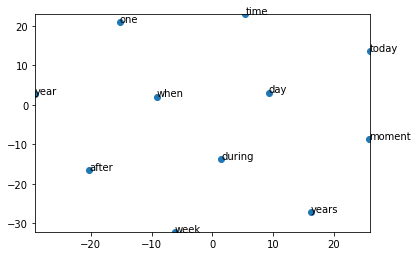

In [226]:
#Visualize the similar words on a scatter plot
display_closestwords_tsnescatterplot(word2vec_model_test,'day')

In [227]:
#Display the vector for the word boston.
word2vec_model_test.wv['day']

array([-0.15039062,  0.07226562,  0.03051758,  0.04150391,  0.01806641,
       -0.03686523,  0.16894531, -0.125     ,  0.21875   ,  0.04589844,
        0.07958984, -0.06347656,  0.15332031, -0.03466797,  0.06054688,
        0.13085938, -0.11914062,  0.03515625,  0.15917969, -0.09277344,
       -0.12353516,  0.00430298,  0.04980469, -0.12109375, -0.08984375,
        0.08789062,  0.11181641,  0.125     ,  0.12402344,  0.07421875,
       -0.04150391,  0.05444336,  0.08007812,  0.0234375 , -0.11230469,
       -0.0168457 , -0.08789062, -0.10644531, -0.08251953,  0.0612793 ,
        0.05981445, -0.0246582 ,  0.23730469,  0.05126953, -0.05297852,
       -0.05249023, -0.10302734,  0.1328125 , -0.07617188,  0.04223633,
        0.02783203, -0.08935547, -0.02734375,  0.09375   ,  0.07128906,
        0.02600098,  0.00552368, -0.01446533,  0.08300781, -0.15234375,
       -0.08203125,  0.09179688, -0.00102997, -0.10205078,  0.10888672,
       -0.012146  , -0.04638672, -0.04150391,  0.0456543 ,  0.04

In [228]:
word2vec_model_test.wv[0]

array([-0.33789062,  0.19824219, -0.296875  ,  0.1484375 , -0.21777344,
       -0.03686523, -0.00582886, -0.12109375,  0.14257812, -0.05053711,
       -0.05908203, -0.07421875, -0.25195312, -0.06835938, -0.12255859,
        0.16308594,  0.00274658,  0.36132812, -0.00567627, -0.12597656,
       -0.29101562, -0.11279297,  0.2578125 , -0.07177734,  0.02368164,
       -0.07519531, -0.3671875 ,  0.02783203, -0.24414062, -0.00830078,
        0.12304688,  0.12060547,  0.00933838,  0.0088501 , -0.10058594,
        0.19824219, -0.4921875 ,  0.14746094,  0.15234375,  0.125     ,
       -0.08300781, -0.15234375,  0.17578125, -0.05541992,  0.00439453,
       -0.03369141,  0.07080078, -0.05371094, -0.12451172,  0.234375  ,
       -0.140625  ,  0.23632812, -0.15332031,  0.61328125,  0.29492188,
       -0.09521484,  0.06494141, -0.15722656, -0.16210938, -0.125     ,
       -0.15527344,  0.05517578, -0.04516602, -0.09423828, -0.00479126,
       -0.27539062, -0.23046875,  0.01477051,  0.0168457 ,  0.11

In [229]:
word2vec_model_test.wv[0].shape

(300,)

#Create Training and Test Sets for Text data
Create the test and training sets for our X and Y.

This is what will be fed into the functional model for the text portion.


In [230]:
print(type(word2vec_model_train.wv))

<class 'gensim.models.keyedvectors.KeyedVectors'>


In [ ]:
### TRAINING
num_of_tweets = 11662
max_tweet_length = 300
vector_size = 300
indexes = set(np.random.choice(num_of_tweets, num_of_tweets, replace=False))

X_train = np.zeros((num_of_tweets, max_tweet_length, vector_size), dtype= np.float32)
Y_train = np.zeros((num_of_tweets, 2), dtype= np.float32)

tweets_train = tweets_train.reset_index(drop=True)

for i, index in enumerate(indexes):
    for t, token in enumerate(tweets_train[index]):
        if t >= max_tweet_length:
            break

        if token not in word2vec_model_train.wv:
            continue
        
        X_train[i, t, :] = word2vec_model_train.wv[token]
            
    Y_train[i, :] = [1.0, 0.0] if df_train.iloc[index]["label"] == "fake" else [0.0, 1.0]   
    #print(df_train.iloc[index]["label"]) 

In [232]:
X_train.shape

(11662, 300, 300)

In [233]:
Y_train.shape

(11662, 2)

In [ ]:
for x in (Y_train):
  print(x)

In [ ]:
### TEST
num_of_tweets = 3755
max_tweet_length = 300
vector_size = 300
indexes = set(np.random.choice(num_of_tweets, num_of_tweets, replace=False))

X_test = np.zeros((num_of_tweets, max_tweet_length, vector_size), dtype= np.float32)
Y_test = np.zeros((num_of_tweets, 2), dtype= np.float32)

tweets_test = tweets_test.reset_index(drop=True)

for i, index in enumerate(indexes):
    for t, token in enumerate(tweets_test[index]):
        if t >= max_tweet_length:
            break

        if token not in word2vec_model_test.wv:
            continue
        
        X_test[i, t, :] = word2vec_model_test.wv[token]
            
    Y_test[i, :] = [1.0, 0.0] if df_test.iloc[index]["label"] == "fake" else [0.0, 1.0]
    #print(df_test.iloc[index]["label"])     

In [240]:
X_test.shape

(3755, 300, 300)

In [241]:
Y_test.shape

(3755, 2)

In [ ]:
for x in (Y_test):
  print(x)

# Image preprocessing

"""
import string
from pprint import pprint

max_sentence_len = 200

with open("/content/drive/MyDrive/Colab Notebooks/data/devset/tweets.txt", encoding = 'utf-8') as file_:
    docs = file_.readlines()
    
sentences = [[word for word in doc.lower().translate(str.maketrans('','',string.punctuation)).split()[:max_sentence_len]] for doc in docs]
print('Num sentences:', len(sentences))
"""

In [137]:
image_file_read = "/content/drive/MyDrive/Colab Notebooks/data/devset/images.txt"

In [138]:
df_images = pd.read_csv(image_file_read,sep='\s+', header=0)

In [139]:
df_images.loc[(df_images['annotation'] != "fake") & (df_images['annotation'] != "real"), 'event'] = df_images['annotation']
df_images.loc[(df_images['annotation'] != "fake") & (df_images['annotation'] != "real"), 'annotation'] = 'fake'

In [140]:
df_images.to_csv("/content/drive/MyDrive/Colab Notebooks/data/devset/images_dataframe.csv", index=False)

In [141]:
df_images.shape

(361, 4)

In [146]:
from PIL import Image, ImageFile
import requests
from io import BytesIO

In [147]:
def load_image(file_name, url):
    try:
        with Image.open(f"/content/drive/MyDrive/Colab Notebooks/data/devset/images/{file_name}.jpg") as img:
            return np.array(img)
    except FileNotFoundError:
        try:
            with Image.open(f"/content/drive/MyDrive/Colab Notebooks/data/devset/images/{file_name}.png") as img:
                return np.array(img)
        except FileNotFoundError:
            try:
                with Image.open(f"/content/drive/MyDrive/Colab Notebooks/data/devset/images/{file_name}.gif") as img:
                    return np.array(img)
            except FileNotFoundError:
                try:
                    with Image.open(f"/content/drive/MyDrive/Colab Notebooks/data/devset/images/{file_name}.jpeg") as img:
                        return np.array(img)
                except FileNotFoundError:
                  print(file_name)

In [151]:
df_images.shape

(361, 4)

In [153]:
for index, row in df_images.iterrows():
    try:
        img_arr = load_image(row["image_id"],row["image_url"])
        if img_arr is not None:
          print("image shape: " + str(img_arr.shape))
        else:
            print("Error: failed to load image", row)
    except (FileNotFoundError, UnidentifiedImageError):
        print("error")
     

image shape: (702, 1342, 3)
image shape: (423, 470, 3)
image shape: (680, 1024, 3)
image shape: (1024, 545, 3)
image shape: (874, 1024, 3)
image shape: (600, 627, 3)
image shape: (878, 500, 3)
image shape: (281, 567, 3)
image shape: (313, 313, 3)
image shape: (434, 388)
image shape: (300, 301, 3)
image shape: (527, 345, 3)
image shape: (217, 1288, 3)
image shape: (346, 599, 3)
image shape: (773, 1024, 3)
image shape: (632, 1041, 3)
image shape: (2048, 1359, 3)
image shape: (2999, 1023, 3)
image shape: (748, 930, 3)
image shape: (2012, 588, 3)
image shape: (600, 600, 3)
image shape: (2032, 2709, 3)
image shape: (932, 2268, 3)
image shape: (1329, 2000, 3)
image shape: (764, 815, 3)
image shape: (2722, 1594, 3)
image shape: (565, 619, 3)
image shape: (695, 1106, 3)
image shape: (1386, 920, 3)
image shape: (455, 620, 3)
image shape: (418, 600, 3)
image shape: (522, 480, 3)
image shape: (449, 600, 3)
image shape: (365, 547, 4)
boston_fake_35
Error: failed to load image image_id             

#Functional Model

Put everything together:

word2vec_model = Neural Network

Image data = CNN

In [ ]:
# first input model
visible1 = Input(shape=(64,64,3))
conv11 = Conv2D(32, kernel_size=(3,3), activation='relu')(visible1)
pool11 = MaxPooling2D(pool_size=(2, 2))(conv11)
conv12 = Conv2D(16, kernel_size=4, activation='relu')(pool11)
pool12 = MaxPooling2D(pool_size=(2, 2))(conv12)
flat1 = Flatten()(pool12)

In [ ]:
# second input model
visible2 = Input(shape=(32,32,3))
conv21 = Conv2D(32, kernel_size=4, activation='relu')(visible2)
pool21 = MaxPooling2D(pool_size=(2, 2))(conv21)
conv22 = Conv2D(16, kernel_size=4, activation='relu')(pool21)
pool22 = MaxPooling2D(pool_size=(2, 2))(conv22)
flat2 = Flatten()(pool22)

In [ ]:

# merge input models
merge = concatenate([flat1, flat2])

In [ ]:
# interpretation model
hidden1 = Dense(10, activation='relu')(merge)
hidden2 = Dense(10, activation='relu')(hidden1)
output = Dense(1, activation='softmax')(hidden2)

In [ ]:

model = Model(inputs=[visible1, visible2], outputs=output)
# summarize layers
print(model.summary())
# plot graph
plot_model(model, show_shapes=True)

#Word2Vec (No longer needed)

Training our model
NOTE: Come back and include test data

REDUNDANT SECTION

In [ ]:
#Create a Word2Vec model for our training data.
print('\nTraining word2vec...')
word_model_train = Word2Vec(tweets_train, vector_size=300, min_count=5, sg=1, window=5, epochs=100)
pretrained_weights = word_model_train.wv.vectors
vocab_size, emdedding_size = pretrained_weights.shape


Training word2vec...


In [ ]:
#Save model and load weights for faster speeds.
word_model_train.save('word2vec_model_scratch')
word_model_train = Word2Vec.load('word2vec_model_scratch')

In [ ]:
#View similar words in the current vocabulary
word_model_train.wv.similar_by_word('boston')

[('suspect', 0.6627120971679688),
 ('bombing', 0.6022583246231079),
 ('marathon', 0.5265966653823853),
 ('zoom', 0.46663346886634827),
 ('bombings', 0.464824914932251),
 ('bomber', 0.4516785740852356),
 ('releases', 0.4490015506744385),
 ('fbi', 0.44374606013298035),
 ('custody', 0.4349137246608734),
 ('bomb', 0.43143191933631897)]

In [ ]:
#View similary words compared to two words
word_model_train.wv.most_similar(positive=['sandy', 'boston'])

[('suspect', 0.4535013735294342),
 ('bombing', 0.4375600516796112),
 ('marathon', 0.3905838429927826),
 ('releases', 0.3534371256828308),
 ('zoom', 0.3406946659088135),
 ('fbi', 0.3402778208255768),
 ('gruber', 0.3320220708847046),
 ('exclusiva', 0.32944199442863464),
 ('pvgb', 0.32841557264328003),
 ('custody', 0.32718586921691895)]

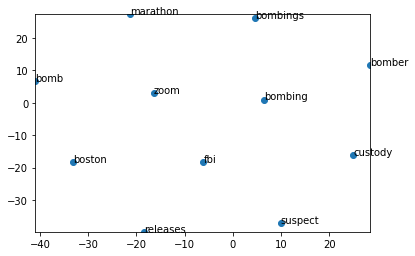

In [ ]:
#Visualize words within a 2D space that are similar to the selected word.
display_closestwords_tsnescatterplot(word_model_train,'boston')   

# (OLD) Data Preprocessing

Import dataset and preprocess it.

In [ ]:
"""
del sentences[0]
"""

In [ ]:
#tweets_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/data/devset/tweet_features.csv', na_values = ['NA', '?'])
#tweets_df

In [ ]:
"""
i = 0
tweets = []
imageID = []
dropped_rows = []
for i in range(len(sentences)):
  if(sentences[i][-1] != "humor"):
    tweets.append(sentences[i][1:-10])
    imageID.append(sentences[i][0:-8])
  #else:
    #tweets_df = tweets_df.drop([i])
    """

'\ni = 0\ntweets = []\nimageID = []\ndropped_rows = []\nfor i in range(len(sentences)):\n  if(sentences[i][-1] != "humor"):\n    tweets.append(sentences[i][1:-10])\n    imageID.append(sentences[i][0:-8])\n  #else:\n    #tweets_df = tweets_df.drop([i])\n    '

In [ ]:
"""
for i in range(len(imageID)):
  if('sandyafake' not in imageID[i]):
    print("Tweet ID: ", imageID[i][0])
    print(imageID[i][-1])
#tweets
"""

In [ ]:
#tweets_df

In [ ]:
"""
print('Num sentences:', len(sentences))
print('Num of sentence without humor:', len(tweets))
#sentences[0][1:-11]
"""

Num sentences: 14483
Num of sentence without humor: 11850


In [ ]:
#https://www.youtube.com/watch?v=ZrgVlfNduj8